## Parameters needed for Scenario 2


### Name mapping
**namemap** : The mapping between the extracted paramters and model paramters. Not normally provided

### **model parameters**:

You can see the parameters being unpacked from the sys object. The user will need to know which parameters are available to achieve this.

@unpack **beta**, **gamma**, **delta**, **alpha**, **epsilon**, **kappa**, **sigma**, **rho**, **xi**, **mu**, **tau**, **lambda**, **eta**, **nu**, **zeta**, **theta** = sys 

ps = [alpha, epsilon, gamma, beta, delta, mu, nu, lambda, rho, kappa, xi, sigma, zeta, eta]

#### default values for each parameter
defaultsmap = Dict(param => val for (param, val) in zip(parameters(sys), paramvals))

### **State variables**:

Same issue of Unpacking. Need to know the state variables of the model to unpack.

@unpack **S**, **I**, **D**, **A**, **R**, **T**, **H**, **E** = sys

#### Map names to state variables

**Infected**, **Healed**, **Extinct**, **Diagnosed**, **Ailing**, **Recognized**, **Susceptible**, **Threatened** = I,H,E,D,A,R,S,T
 
**U0vals** Need default values for all state variables.

## Analysis/Unit tests

**idart** 

A subset of state variables. Looks like this can be created easily in the ui. If we have the mapping created between state variables.

idart = [Infected, Diagnosed, Ailing, Recognized, Threatened]


**plot_uncertainty_forecast**

This takes in an ode problem, a state variable, 0.0:1:100.0, param_priors, and 50 not sure what 50 is for.
Might need human in the loop to help create these. but maybe not if its just a standard procedure. 

**sensitivity analysis** looks like it can be automated if parameters are set correctly. 

 **Minimum Parameter Threshold**

Looks very custom. Lots of paramters and not sure if this can be automated. 

**threshold_observable** = (Infected + Diagnosed + Ailing + Recognized + Threatened) /
                       sum(states(sys))

**cost** = (epsilon + theta)

**ineq_cons** = [2 * epsilon - theta]

additional parameters needed: **0.33**, **[epsilon, theta]**, **3**, **maxtime**, **ineq_cons**

optimal_parameter_threshold(probne, threshold_observable,
                                                    0.33,
                                                    cost, [epsilon, theta],
                                                    [0.0, 0.0],
                                                    3 .* [
                                                        defaultsmap[epsilon],
                                                        defaultsmap[theta],
                                                    ];
                                                    maxtime = 60,
                                                    ineq_cons);
opt_p

**sidarthe_V**

Same as above for the most part plus. 
    
**intervention_parameters**

**optimal_parameter_intervention_for_threshold** 

function similar to optimal_parameter_threshold. Some can be selected by the user but need some way for the user to know what they are changing and why

params needed:

1. probv,
2. **threshold_observable**,
3. **0.33**,
4. **cost** (𝑒𝑝𝑠𝑖𝑙𝑜𝑛+𝑡ℎ𝑒𝑡𝑎)
5. **[intervention_p]**, 
6. **[0.0]**,
7. **[1.0]**,
8. **(30.0, 100.0)**;
9. **maxtime = 10**

## Additional thoughts
1. Looks like the "evaluation on effects of events" code can be done without human in the loop? Just ran every time and returned.
2. The unpack function needs to know what is in the sys before it can unpack them. This could be somewhat automated but it won't look this this code.
3. We will need to allow the use to create new parameters using the current model parameters to create intervention senarios. 


In [1]:
using Catlab, AlgebraicPetri, Catlab.CategoricalAlgebra, ModelingToolkit
using AlgebraicPetri.SubACSets
sidarthe = read_json_acset(LabelledPetriNet, "sidarthe.json")
sys = ODESystem(sidarthe)

Model PetriNet with 8 equations
States (8):
  S(t)
  H(t)
  R(t)
  T(t)
  D(t)
  I(t)
⋮
Parameters (16):
  beta
  gamma
  delta
  alpha
  epsilon
  kappa
⋮

8-element Vector{Float64}:
 0.9999963
 0.0
 3.33333333e-8
 0.0
 3.33333333e-7
 3.33333333e-6
 1.66666666e-8
 0.0

In [10]:
using EasyModelAnalysis, SBML, SBMLToolkit, UnPack, Test

fn = "Giordano2020.xml"

myread(fn) = readSBML(fn, doc -> begin
                          set_level_and_version(3, 2)(doc)
                          convert_promotelocals_expandfuns(doc)
                      end)

m = myread(fn)

paramvals = map(name -> m.parameters[string(name)].value, tnames(sidarthe))
namemap = Dict(:S => "Susceptible", :I => "Infected", :D => "Diagnosed", :A => "Ailing",
               :R => "Recognized",
               :T => "Threatened", :H => "Healed", :E => "Extinct")
u0vals = map(name -> m.species[namemap[name]].initial_concentration, snames(sidarthe))
let S, I, D, A, R, T, H, E
    @unpack S, I, D, A, R, T, H, E = sys
    global Infected, Healed, Extinct, Diagnosed, Ailing, Recognized, Susceptible, Threatened
    Infected, Healed, Extinct, Diagnosed, Ailing, Recognized, Susceptible, Threatened = I,
                                                                                        H,
                                                                                        E,
                                                                                        D,
                                                                                        A,
                                                                                        R,
                                                                                        S, T
end
@unpack beta, gamma, delta, alpha, epsilon, kappa, sigma, rho, xi, mu, tau, lambda, eta, nu, zeta, theta = sys
ps = [alpha, epsilon, gamma, beta, delta, mu, nu, lambda, rho, kappa, xi, sigma, zeta, eta]
defaultsmap = Dict(param => val for (param, val) in zip(parameters(sys), paramvals))



Dict{Sym{Real, Base.ImmutableDict{DataType, Any}}, Float64} with 16 entries:
  alpha   => 0.57
  delta   => 0.011
  xi      => 0.017
  epsilon => 0.171
  mu      => 0.017
  zeta    => 0.125
  nu      => 0.027
  beta    => 0.011
  kappa   => 0.017
  sigma   => 0.017
  lambda  => 0.034
  eta     => 0.125
  theta   => 0.371
  gamma   => 0.456
  tau     => 0.01
  rho     => 0.034

In [11]:
function LogNormalPrior(mean, variance)
    μ = log(mean^2 / sqrt(mean^2 + variance))
    σ = sqrt(log(1 + variance / mean^2))
    LogNormal(μ, σ)
end

function create_priors(defaultsmap)
    param_priors = [p => LogNormalPrior(defaultsmap[p], defaultsmap[p]*0.01) for p in keys(defaultsmap)]
    return param_priors
end

create_priors (generic function with 1 method)

In [12]:
# provided by ta1
u0vals

8-element Vector{Float64}:
 0.9999963
 0.0
 3.33333333e-8
 0.0
 3.33333333e-7
 3.33333333e-6
 1.66666666e-8
 0.0

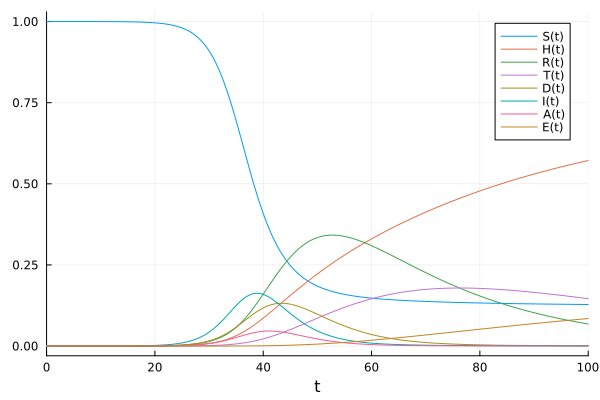

In [14]:
ssys = structural_simplify(sys)
probne = ODEProblem(ssys, u0vals, (0.0, 100.0), paramvals)
solne = solve(probne, Tsit5())
plot(solne)

In [15]:
idart = [Infected, Diagnosed, Ailing, Recognized, Threatened]
xmax, xmaxval = get_max_t(probne, sum(idart))
@test isapprox(xmax, 47; atol = 0.5)
@test isapprox(xmaxval, 0.6, atol = 0.01)

Test Passed

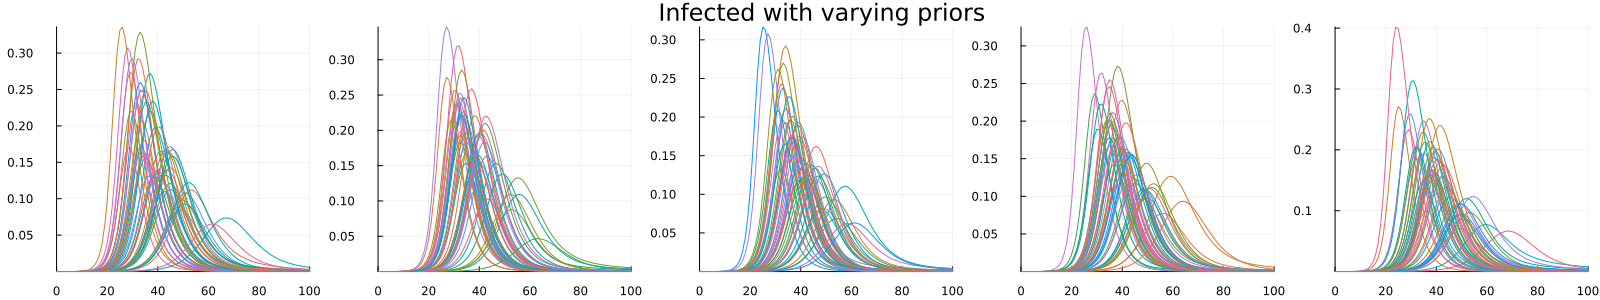

In [16]:
param_priors = create_priors(defaultsmap)

_p = []
for (i,var) in enumerate([0.0001, 0.001, 0.01, 0.1, 1])
    push!(_p, plot_uncertainty_forecast(probne, [Infected], 0.0:1:100.0, param_priors, 50))
end
plot(_p..., layout = (1, 5), size = (1600, 300), plot_title = "Infected with varying priors", legend = false)



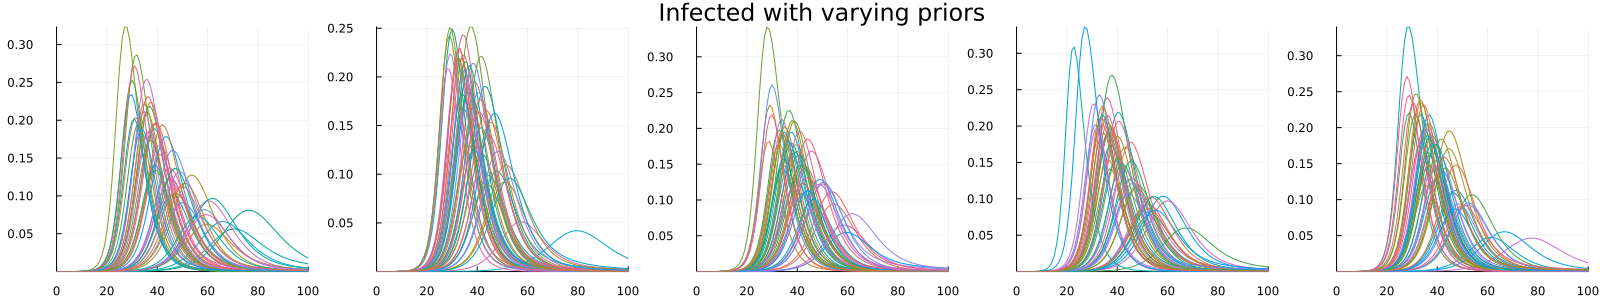

In [18]:
param_priors = create_priors(defaultsmap)

_p = []
for (i,var) in enumerate([0.0001, 0.001, 0.01, 0.1, 1])
    push!(_p, plot_uncertainty_forecast(probne, [Infected], 0.0:1:100.0, param_priors, 50))
end
plot(_p..., layout = (1, 5), size = (1600, 300), plot_title = "Infected with varying priors", legend = false)

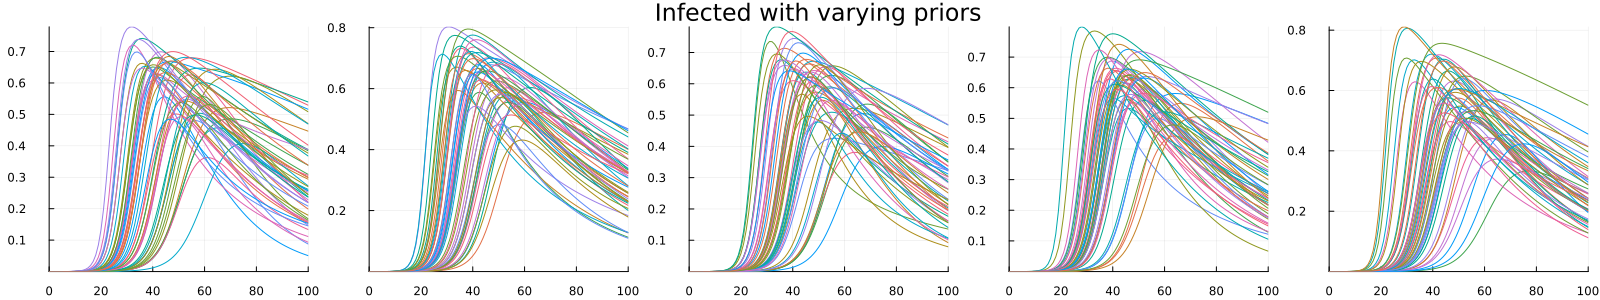

In [19]:
_p = []
for (i,var) in enumerate([0.0001, 0.001, 0.01, 0.1, 1])
    push!(_p, plot_uncertainty_forecast(probne, [sum(idart)], 0.0:1:100.0, param_priors, 50))
end
plot(_p..., layout = (1, 5), size = (1600, 300), plot_title = "Infected with varying priors", legend = false)

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


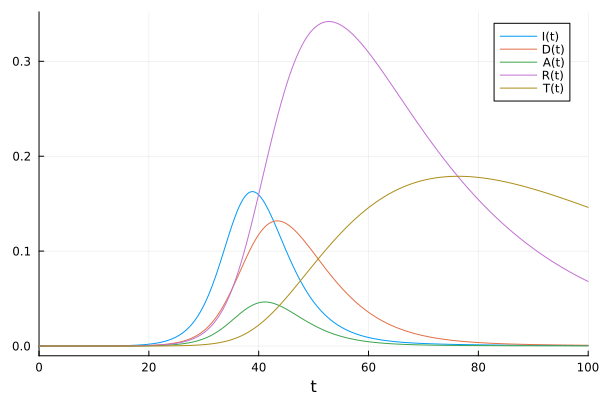

In [20]:
solne = solve(probne, Tsit5())
p = plot(solne, vars = idart)

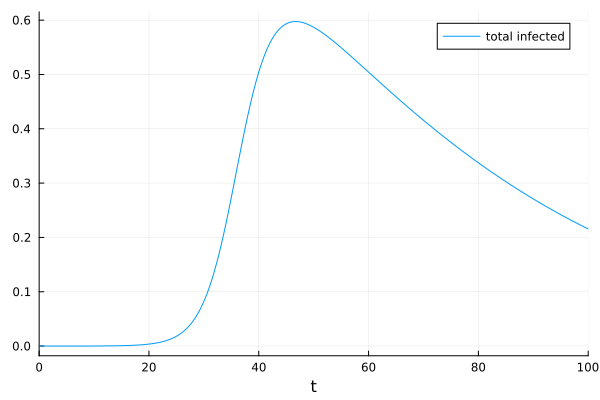

In [21]:
p = plot(solne, idxs = [sum(idart)], lab = "total infected")


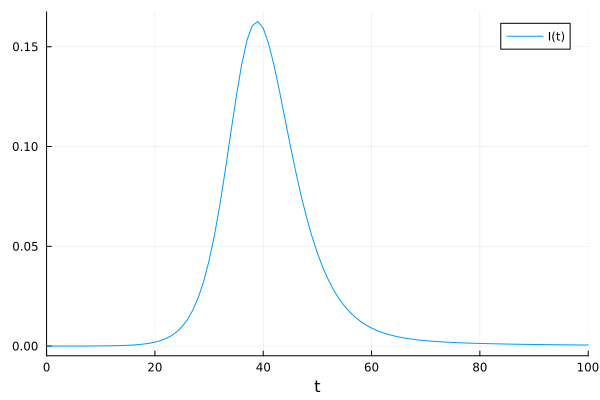

In [22]:
ITALY_POPULATION = 60e6
u0s = [
    Infected => 200 / ITALY_POPULATION,
    Diagnosed => 20 / ITALY_POPULATION,
    Ailing => 1 / ITALY_POPULATION,
    Recognized => 2 / ITALY_POPULATION,
    Threatened => 0,
    Healed => 0,
    Extinct => 0,
]
push!(u0s, Susceptible => 1 - sum(last.(u0s)))

# The resulting basic reproduction number is R0 = 2.38.
pars = [alpha => 0.570, beta => 0.011, delta => 0.011, gamma => 0.456, epsilon => 0.171,
    theta => 0.371,
    zeta => 0.125, eta => 0.125, mu => 0.017, nu => 0.027, tau => 0.01,
    lambda => 0.034, rho => 0.034, kappa => 0.017, xi => 0.017, sigma => 0.017]
prob = ODEProblem(ssys, u0vals, (0, 100), paramvals)
prob_test1 = remake(prob, u0 = u0s, p = pars)
solt1 = solve(prob_test1, Tsit5(); saveat = 0:100)
og_states = states(sys)[1:8]
idart = [Infected, Diagnosed, Ailing, Recognized, Threatened]
plot(solt1; idxs = Infected)



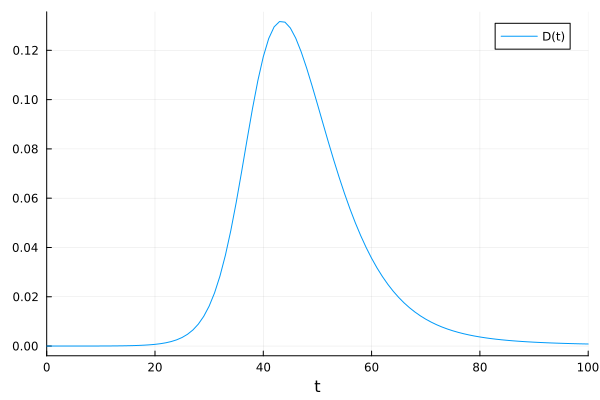

In [23]:
plot(solt1; idxs = Diagnosed)


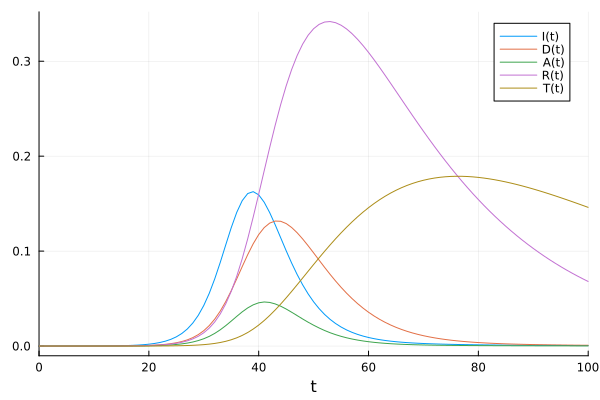

In [24]:
plot(solt1; idxs = idart)


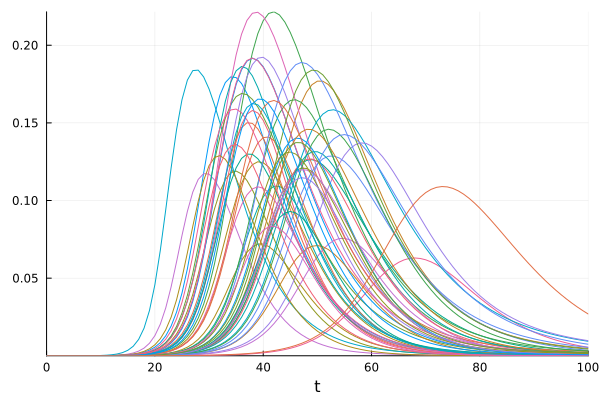

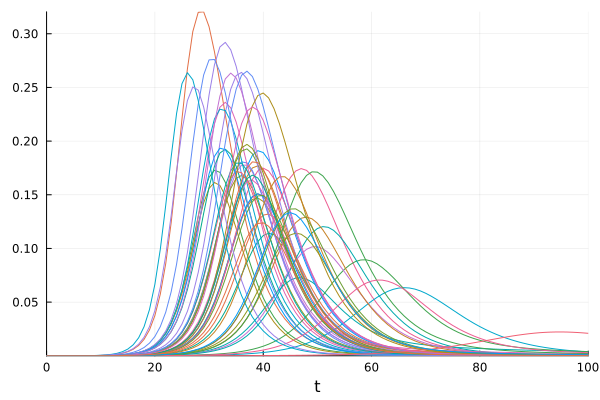

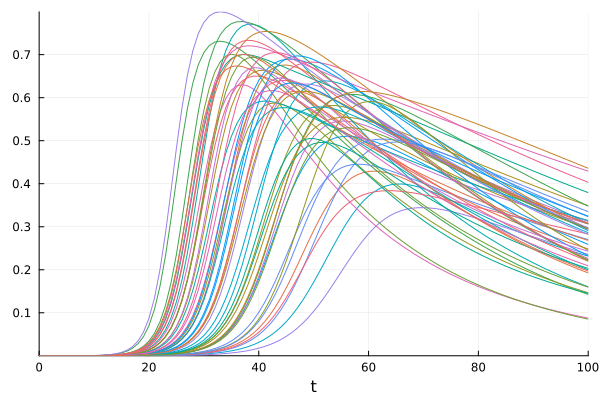

In [25]:
param_priors = create_priors(Dict(pars))

for obs in [Diagnosed, Infected, sum(idart)]
    display(plot_uncertainty_forecast(probne, [obs], 0.0:1:100.0, param_priors, 50))
end

## sensitivity analysis


In [26]:
pbounds = [param => [
               0.5 * defaultsmap[param],
               2 * defaultsmap[param],
           ] for param in parameters(sys)]
sensres = get_sensitivity(probne, 100.0, Infected, pbounds; samples = 200)
sensres_vec = collect(sensres)
sort(filter(x -> endswith(string(x[1]), "_first_order"), sensres_vec), by = x -> abs(x[2]),
     rev = true)

16-element Vector{Pair{Symbol, Float64}}:
   :alpha_first_order => 0.38628985817564593
    :zeta_first_order => 0.07154565714757369
 :epsilon_first_order => 0.06675225096211086
   :gamma_first_order => 0.041833524123909206
   :theta_first_order => 0.035761396988486537
   :delta_first_order => 0.027790819656210306
      :nu_first_order => -0.007399089331720475
      :xi_first_order => 0.006253136258390504
     :eta_first_order => 0.005346519871521887
    :beta_first_order => 0.004431619174940082
      :mu_first_order => -0.003892971983496497
  :lambda_first_order => -0.0022730255594825676
     :rho_first_order => 0.0010154102440947687
   :kappa_first_order => 0.00010352442399870258
   :sigma_first_order => -2.91401880213798e-7
     :tau_first_order => -1.6073752568842485e-7

In [28]:
sort(filter(x -> endswith(string(x[1]), "_second_order"), sensres_vec), by = x -> abs(x[2]),
     rev = true)

120-element Vector{Pair{Symbol, Float64}}:
     :alpha_zeta_second_order => -0.37928084200214085
      :alpha_eta_second_order => -0.33007962919814304
    :alpha_kappa_second_order => -0.32530980234088713
       :alpha_xi_second_order => -0.32238421561602504
      :alpha_tau_second_order => -0.32212546062461256
    :alpha_sigma_second_order => -0.3221249621462015
      :alpha_rho_second_order => -0.3214433879949847
       :alpha_mu_second_order => -0.3167756813036434
       :alpha_nu_second_order => -0.3104280466188027
   :alpha_lambda_second_order => -0.22522518681167764
    :alpha_theta_second_order => -0.20048649701938495
   :epsilon_zeta_second_order => -0.15454017248736993
 :epsilon_lambda_second_order => -0.1418861458557428
                              ⋮
      :sigma_tau_second_order => 2.8102711613324177e-7
       :sigma_mu_second_order => 2.807649206168243e-7
      :sigma_eta_second_order => 2.796406723065251e-7
      :sigma_rho_second_order => 2.7920036926358535e-7
       :si

In [29]:
sort(filter(x -> endswith(string(x[1]), "_total_order"), sensres_vec), by = x -> abs(x[2]),
     rev = true)

16-element Vector{Pair{Symbol, Float64}}:
   :alpha_total_order => 0.625412069389691
   :gamma_total_order => 0.3356073673024599
   :theta_total_order => 0.20270220536912503
  :lambda_total_order => -0.16360337130901562
 :epsilon_total_order => 0.03728843492442525
    :zeta_total_order => -0.034757918254463734
   :delta_total_order => -0.025011329571358397
    :beta_total_order => -0.016687338260939873
   :kappa_total_order => 0.0108396006026423
      :xi_total_order => -0.0029588864480605565
     :rho_total_order => -0.0011632093294488288
     :eta_total_order => -0.0009498087356640952
      :nu_total_order => 0.0004330280433801223
      :mu_total_order => 0.00011940679013631728
   :sigma_total_order => 1.8136499778288995e-8
     :tau_total_order => -5.883439050246807e-10

In [34]:
create_sensitivity_plot(sensres, pbounds, true, (-0.2, 1.0), (800, 800))


LoadError: MethodError: no method matching create_sensitivity_plot(::Dict{Symbol, Float64}, ::Vector{Pair{Sym{Real, Base.ImmutableDict{DataType, Any}}, Vector{Float64}}}, ::Bool, ::Tuple{Float64, Float64}, ::Tuple{Int64, Int64})
[0mClosest candidates are:
[0m  create_sensitivity_plot(::Any, ::Any, ::Any, ::Any; samples) at ~/.julia/packages/EasyModelAnalysis/7vQch/src/sensitivity.jl:91
[0m  create_sensitivity_plot(::Dict{Symbol}, ::Any) at ~/.julia/packages/EasyModelAnalysis/7vQch/src/sensitivity.jl:115


## Minimum Parameter Threshold

Now return to the situation in b.i (constant parameters that don’t change over time). Let’s say we want to increase testing, diagnostics, and contact tracing efforts (implemented by increasing the detection parameters ε and θ). Assume that θ >= 2* ε, because a symptomatic person is more likely to be tested. What minimum constant values do these parameters need to be over the course of a 100-day simulation, to ensure that the total infected population (sum over all the infected states I, D, A, R, T) never rises above 1/3 of the total population?

This scenario demonstrates the lazily defined observables functionality that persists throughout our simulation and analysis libraries. When one solves an equation with ModelingToolkit symbolic values, sol[x] gives the solution with respect to x by name. While that improves code legibility, sol[x+y] is also allowed, and will automatically generate the solution of x(t) + y(t) on demand. Since this functionality is directly handled by the solution representation, this means that all functions built on the solution have this functionality. Thus without having to make any other changes, we can change our minimization to the complex form (Infected + Diagnosed + Ailing + Recognized + Threatened) / sum(states(sys)) required by the scenario.



In [35]:
threshold_observable = (Infected + Diagnosed + Ailing + Recognized + Threatened) /
                       sum(states(sys))
cost = (epsilon + theta)
ineq_cons = [2 * epsilon - theta]
opt_p, sol_opt_p, ret = optimal_parameter_threshold(probne, threshold_observable,
                                                    0.33,
                                                    cost, [epsilon, theta],
                                                    [0.0, 0.0],
                                                    3 .* [
                                                        defaultsmap[epsilon],
                                                        defaultsmap[theta],
                                                    ];
                                                    maxtime = 60,
                                                    ineq_cons);
opt_p

Dict{Num, Float64} with 2 entries:
  epsilon => 0.331443
  theta   => 0.662945

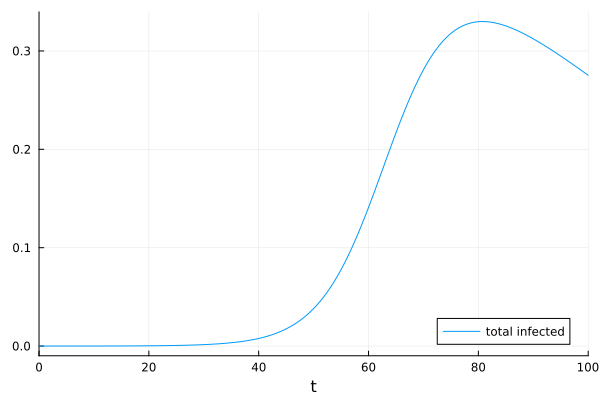

In [39]:
plot(sol_opt_p, idxs = [threshold_observable], lab = "total infected", leg = :bottomright)


In [42]:
using Pkg
Pkg.add("Graphviz_jil")

    Updating registry at `~/.julia/registries/General.toml`


LoadError: The following package names could not be resolved:
 * Graphviz_jil (not found in project, manifest or registry)
[36m   Suggestions:[39m [0m[1mG[22m[0m[1mr[22m[0m[1ma[22m[0m[1mp[22m[0m[1mh[22m[0m[1mv[22m[0m[1mi[22m[0m[1mz[22m[0m[1m_[22m[0m[1mj[22mll

## Form SIDARTHE-V model

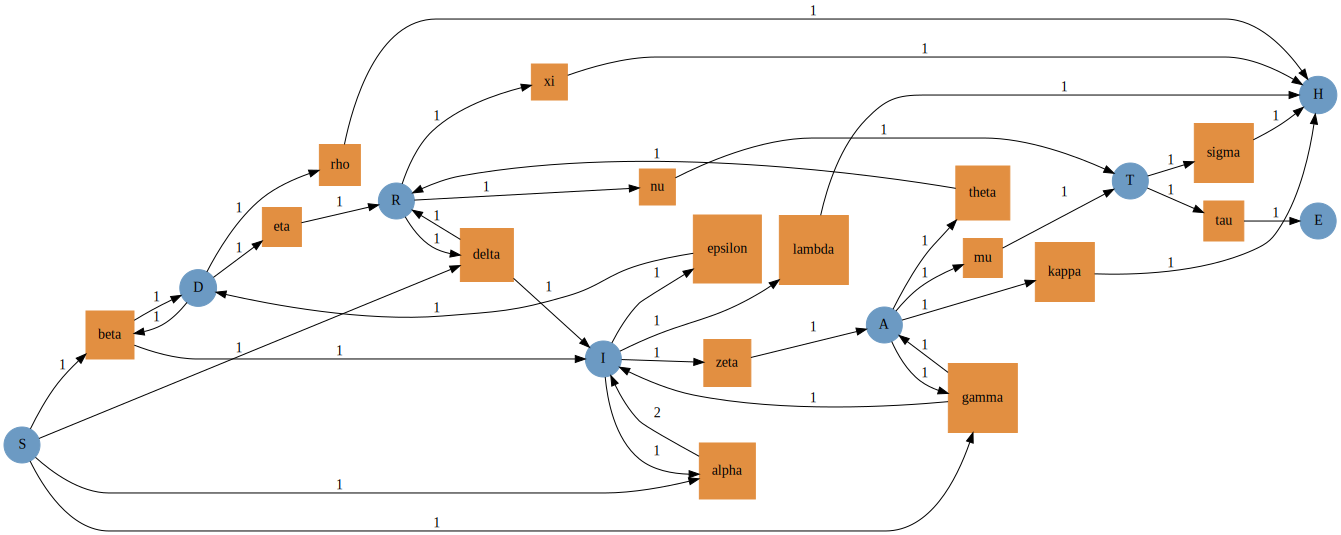

In [46]:
import Graphviz_jll
sidarthe_v = read_json_acset(LabelledPetriNet, "sidarthe_v.json")
sidarthe = read_json_acset(LabelledPetriNet, "sidarthe.json")

mca_sidarthe_v = mca(sidarthe, sidarthe_v)
AlgebraicPetri.Graph(mca_sidarthe_v[1])

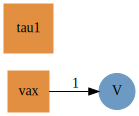

In [47]:
sidarthe_sub = Subobject(sidarthe_v,
                         S = parts(sidarthe, :S),
                         T = parts(sidarthe, :T),
                         I = parts(sidarthe, :I),
                         O = parts(sidarthe, :O))
AlgebraicPetri.Graph(dom(hom(negate(sidarthe_sub))))

In [48]:
sysv = ODESystem(sidarthe_v)
u0valsv = [u0vals; 0.0]  # 0 vaccinated initially
@unpack beta, gamma, delta, alpha, epsilon, kappa, sigma, rho, xi, mu, tau1, tau2, lambda, eta, nu, zeta, theta, vax = sysv
phi = vax
p_map = Dict([parameters(sys) .=> paramvals
              tau2 => defaultsmap[tau]
              tau1 => defaultsmap[tau] / 3
              vax => 0.0])
sts_map = Dict(states(sysv) .=> u0valsv)
using ModelingToolkit: @set!
defs_v2 = merge(sts_map, p_map)
@set! sysv.defaults = defs_v2
sysv = complete(sysv)

Model PetriNet with 9 equations
States (9):
  S(t) [defaults to 0.999996]
  H(t) [defaults to 0.0]
  R(t) [defaults to 3.33333e-8]
  T(t) [defaults to 0.0]
  D(t) [defaults to 3.33333e-7]
  I(t) [defaults to 3.33333e-6]
⋮
Parameters (18):
  beta [defaults to 0.011]
  gamma [defaults to 0.456]
  delta [defaults to 0.011]
  alpha [defaults to 0.57]
  epsilon [defaults to 0.171]
  kappa [defaults to 0.017]
⋮

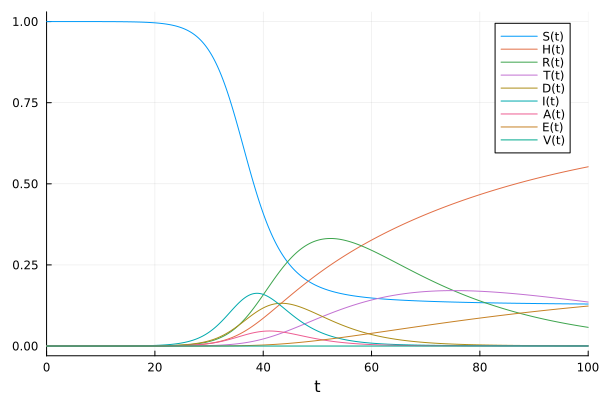

In [49]:
probv = ODEProblem(sysv, [], (0, 100))
solv = solve(probv, Tsit5())
plot(solv)

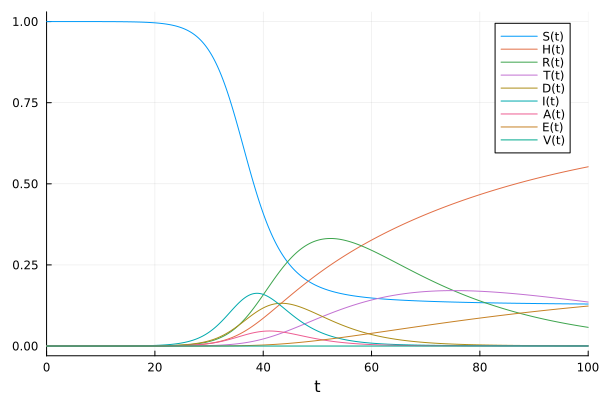

In [50]:
plot(solv, idxs = [og_states; sysv.V])


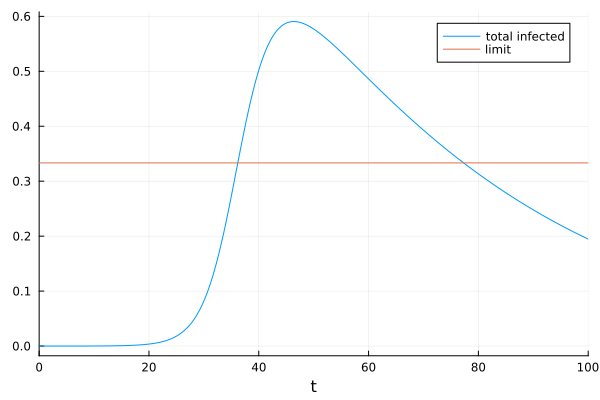

In [51]:
threshold_observable = (Infected + Diagnosed + Ailing + Recognized + Threatened) /
                       sum(states(sysv))
plot(solv, idxs = [threshold_observable], lab = "total infected")
hline!([1 / 3], lab = "limit")

In [52]:
intervention_parameters = [theta => (2 * defs_v2[epsilon], 1) # 𝜃 >= 2 * 𝜀
                           epsilon => (0, defs_v2[theta] / 2)
                           phi => (0, 1)]

opt_results = map(intervention_parameters) do (intervention_p, bounds)
    cost = intervention_p - defs_v2[intervention_p]
    optimal_parameter_intervention_for_threshold(probv,
                                                 threshold_observable,
                                                 0.33,
                                                 cost,
                                                 [intervention_p], [0.0],
                                                 [1.0],
                                                 (30.0, 100.0);
                                                 maxtime = 10)
end;
map(first, opt_results)

3-element Vector{Dict{Num, Float64}}:
 Dict(theta => 0.9999964087574185)
 Dict(epsilon => 0.417272047645448)
 Dict(vax => 0.05610590086562467)

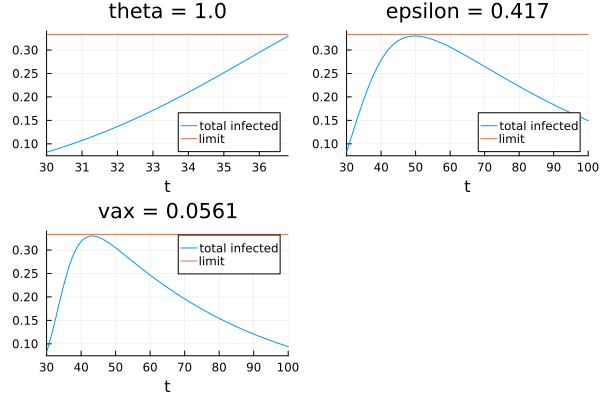

In [58]:
plts = map(opt_results) do opt_result
    title = only(collect(opt_result[1]))
    title = string(title[1], " = ", round(title[2], sigdigits = 3))
    plot(opt_result[2][2]; idxs = [threshold_observable], lab = "total infected", title)
    hline!([1 / 3], lab = "limit")
end
plot(plts...)

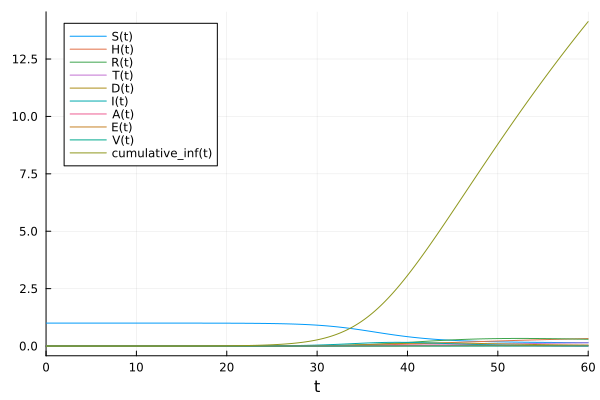

In [59]:
@unpack S, I, D, A, R, T = sysv
r1 = epsilon + xi + lambda
r2 = eta + rho
r3 = theta + mu + kappa
r4 = nu + xi + tau1
r5 = sigma + tau2
R0 = (alpha + beta * epsilon / r2 + gamma * zeta / r3 +
      delta * ((eta * epsilon /
                (r2 * r4)) + (zeta * theta) / (r3 * r4))) / r1
R_t = S * R0
plot(solv, idxs = [R_t], lab = "R_t")
@variables t cumulative_inf(t)
total_inf = (I + D + A + R + T) / sum(states(sysv))
sysva = add_accumulations(sysv, [cumulative_inf => total_inf])
using ModelingToolkit: @set!
@set! sysva.defaults = defs_v2
u03 = [u0valsv; 0.0]
probv3 = ODEProblem(sysva, u03, (0, 60.0))
solv3 = solve(probv3)
plot(solv3)



In [60]:
intervention_parameters = [theta => (2 * defs_v2[epsilon], 3) # 𝜃 >= 2 * 𝜀
                           epsilon => (0, defs_v2[theta] / 2)
                           phi => (0, 1)]
sol_cost = sol -> begin sol(sol.t[end], idxs = cumulative_inf) end
opt_results = map(intervention_parameters) do (intervention_p, bounds)
    cost = intervention_p - defs_v2[intervention_p]
    optimal_parameter_intervention_for_reach(probv3,
                                             R_t,
                                             1.0,
                                             (cost, sol_cost),
                                             [intervention_p], [bounds[1]], [bounds[2]],
                                             maxtime = 10)
end;
map(first, opt_results)

3-element Vector{Dict{Num, Float64}}:
 Dict(theta => 1.671)
 Dict(epsilon => 0.09275)
 Dict(vax => 0.5)

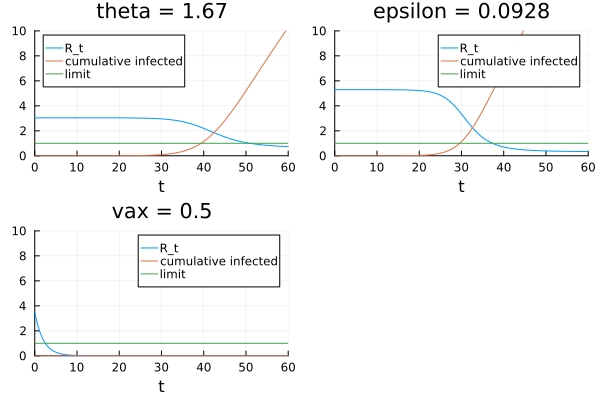

In [61]:
plts = map(opt_results) do opt_result
    title = only(collect(opt_result[1]))
    title = string(title[1], " = ", round(title[2], sigdigits = 3))
    plot(opt_result[2][2]; idxs = [R_t], lab = "R_t", title)
    plot!(opt_result[2][2]; idxs = [cumulative_inf], lab = "cumulative infected", title)
    hline!([1], lab = "limit", ylims = (0, 10))
end
plot(plts...)